In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing
import json
from sklearn.metrics import pairwise_distances
# pandas show all columns
pd.set_option('display.max_columns', None)

In [2]:
# Load the variables
with open('./utils/variables.json', 'r') as file:
    variables = json.load(file)

SCR_feature_space = variables['SCR_feature_space']
LAB_feature_space = variables['LAB_feature_space']
train_len = variables['train_len']
test_len = variables['test_len']
print(len(SCR_feature_space), len(LAB_feature_space))
print(train_len, test_len)

# get num_processors for parallel computing
num_processors = multiprocessing.cpu_count()

7 40
8637 8542


# Process UPITT Dataset

In [3]:
#Read in Onsets data and only use KUMC data
All_onsets = pd.read_csv('/blue/yonghui.wu/lideyi/Personalization_Methodology/NEW_ONSETS.csv')
ext_ONSET = All_onsets.loc[All_onsets.CENTER_NAME == "UPITT"].copy(deep = True)

/scratch/local/52881804/ipykernel_1337165/2764998025.py:2: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  All_onsets = pd.read_csv('/blue/yonghui.wu/lideyi/Personalization_Methodology/NEW_ONSETS.csv')


In [4]:
#read in lab
raw_path = '/blue/yonghui.wu/hoyinchan/Data/data2022raw/'
data_path = raw_path + "UPITT" + '/raw/'
ext_LAB = pd.read_csv(data_path + 'AKI_LAB.csv', delimiter = ',', usecols = ['PATID', 'LAB_LOINC', 'SPECIMEN_DATE', 'RESULT_NUM'])

In [5]:
# Read in SCr trajectories
SCR_use_cols = ['ONSETS_ENCOUNTERID','PATID','ENCOUNTERID','SPECIMEN_DATE','RESULT_NUM', 'DAYS_SINCE_ADMIT']
ext_SCR = pd.read_csv(data_path + "AKI_LAB_SCR.csv", delimiter = ',', usecols=SCR_use_cols)

In [6]:
#format datatype for merge
#exclude those baseline SCr > 3.5, which indicate poor renal functions
ext_ONSET = ext_ONSET.loc[ext_ONSET.SERUM_CREAT_BASE < 3.5, :].copy(deep = True)

ext_ONSET.loc[:, ["PATID", "ONSETS_ENCOUNTERID"]] = ext_ONSET[["PATID", "ONSETS_ENCOUNTERID"]].astype(str)

time_cols = ["ADMIT_DATE", "DISCHARGE_DATE", "AKI1_ONSET", "AKI2_ONSET", "AKI3_ONSET"]
for time_col in time_cols:
    ext_ONSET[time_col] = pd.to_datetime(ext_ONSET[time_col], format = "mixed")
    
# binary predictiton task
ext_ONSET.loc[:, "EARLIEST_ONSET_DATE"] = np.min(ext_ONSET[["AKI1_ONSET", "AKI2_ONSET", "AKI3_ONSET"]], axis = 1)
ext_ONSET.loc[:, "AKI_LABEL"] = ext_ONSET["EARLIEST_ONSET_DATE"].notna().astype(int)

ext_ONSET.drop(["CENTER_NAME", "SERUM_CREAT_BASE", "NONAKI_SINCE_ADMIT", "AKI1_ONSET",
           "AKI2_ONSET", "AKI3_ONSET"], axis = 1, inplace = True)

#process data type 
ext_SCR["PATID"] = ext_SCR["PATID"].astype(str)

In [7]:
ext_ONSET_SCR = ext_ONSET.merge(ext_SCR[["PATID", "SPECIMEN_DATE", "RESULT_NUM"]], on = "PATID", how = "left")
#after merging, process date time
ext_ONSET_SCR["SPECIMEN_DATE"] = pd.to_datetime(ext_ONSET_SCR["SPECIMEN_DATE"], format = "mixed")
#filter out those beyond this hospitalization (we also need history prior to this hospitalization)
ext_ONSET_SCR = ext_ONSET_SCR.loc[ext_ONSET_SCR.SPECIMEN_DATE <= ext_ONSET_SCR.DISCHARGE_DATE, :]
ext_ONSET_SCR = ext_ONSET_SCR.sort_values(by=['PATID', 'ADMIT_DATE', 'SPECIMEN_DATE'])
# get average SCr on the same day
ext_ONSET_SCR_avg = ext_ONSET_SCR.groupby(['PATID', 'ONSETS_ENCOUNTERID', 'SPECIMEN_DATE'])['RESULT_NUM'].mean().reset_index()

In [8]:
# append the info back
ext_ONSET_SCR_app = ext_ONSET_SCR.loc[:, ["PATID", "ONSETS_ENCOUNTERID", "ADMIT_DATE", "DISCHARGE_DATE", "EARLIEST_ONSET_DATE", "AKI_LABEL"]]
ext_ONSET_SCR_app.drop_duplicates(inplace = True)
ext_ONSET_SCR_avg = ext_ONSET_SCR_app.merge(ext_ONSET_SCR_avg, on = ["PATID", "ONSETS_ENCOUNTERID"], how = "left")

In [9]:
# get the prediction point for non-AKI patient
ext_non_AKI_pat = ext_ONSET_SCR_avg.loc[ext_ONSET_SCR_avg.AKI_LABEL == 0, ["PATID", "ONSETS_ENCOUNTERID", "SPECIMEN_DATE"]]
ext_non_AKI_pat.drop_duplicates(subset = ["PATID", "ONSETS_ENCOUNTERID"], keep = "last", inplace = True)
ext_non_AKI_pat.rename(columns = {"SPECIMEN_DATE": "PREDICTION_POINT"}, inplace = True)
ext_ONSET_SCR_avg = ext_ONSET_SCR_avg.merge(ext_non_AKI_pat, on = ["PATID", "ONSETS_ENCOUNTERID"], how = "left")

In [10]:
ext_ONSET_SCR_avg.loc[ext_ONSET_SCR_avg.AKI_LABEL == 1, "PREDICTION_POINT"] = ext_ONSET_SCR_avg.loc[ext_ONSET_SCR_avg.AKI_LABEL == 1, "EARLIEST_ONSET_DATE"]
#check that we have predicition point for each encounter
assert(ext_ONSET_SCR_avg.PREDICTION_POINT.isna().mean() == 0)

In [11]:
# the time frame we need for SCr is the -8 to -2 days prior to prediction point
ext_ONSET_SCR_avg = ext_ONSET_SCR_avg[((ext_ONSET_SCR_avg.SPECIMEN_DATE <= (ext_ONSET_SCR_avg.PREDICTION_POINT) - pd.Timedelta(days=2))) & \
                             (ext_ONSET_SCR_avg.SPECIMEN_DATE >= ext_ONSET_SCR_avg.PREDICTION_POINT - pd.Timedelta(days=8))]
#drop patients with less than 2 SCr measurements during the 7-day window
# group them and calcualte number of measurements
measure_num = ext_ONSET_SCR_avg.groupby('ONSETS_ENCOUNTERID').size()
encounterID_to_drop = measure_num[measure_num < 2].index
ext_ONSET_SCR_avg = ext_ONSET_SCR_avg.loc[~ext_ONSET_SCR_avg.ONSETS_ENCOUNTERID.isin(encounterID_to_drop), :]

In [12]:
#pivot all the SCr values, that is create features -8 ~ -2 and entries are RESULT_NUM
ext_ONSET_SCR_avg["DAYS_BEFORE_PREDICTION_POINT"] = (ext_ONSET_SCR_avg["SPECIMEN_DATE"] - ext_ONSET_SCR_avg["PREDICTION_POINT"]).dt.days

#prepare a skleleton to merge on
unique_encounterids = list(ext_ONSET_SCR_avg['ONSETS_ENCOUNTERID'].unique())
time_window = np.arange(-8, -1)  # from -8 to -2
skeleton = pd.MultiIndex.from_product([unique_encounterids, time_window], 
                                      names=['ONSETS_ENCOUNTERID', 'DAYS_BEFORE_PREDICTION_POINT']).to_frame(index=False)
#merge on
skeleton = pd.merge(skeleton, ext_ONSET_SCR_avg, on=['ONSETS_ENCOUNTERID', 'DAYS_BEFORE_PREDICTION_POINT'], how='left')

#pivot
ONSET_SCR_formatted = skeleton.pivot(index='ONSETS_ENCOUNTERID', 
                                          columns='DAYS_BEFORE_PREDICTION_POINT', 
                                          values='RESULT_NUM').reset_index()

# get other info back
ONSET_SCR_app2 = ext_ONSET_SCR_avg.loc[:, ["PATID", "ONSETS_ENCOUNTERID", "ADMIT_DATE", "DISCHARGE_DATE", 
                                       "PREDICTION_POINT", "AKI_LABEL"]]
ONSET_SCR_app2.drop_duplicates(inplace = True)
ext_ONSET_SCR_formatted = ONSET_SCR_formatted.merge(ONSET_SCR_app2, on = "ONSETS_ENCOUNTERID", how = "left")

In [13]:
# only keep the earliest encounter of each patient
ext_ONSET_SCR_formatted = ext_ONSET_SCR_formatted.sort_values(by=['PATID', 'ADMIT_DATE'])
ext_ONSET_SCR_formatted = ext_ONSET_SCR_formatted.drop_duplicates(subset='PATID', keep='first')

In [14]:
ext_LAB["PATID"] = ext_LAB["PATID"].astype(str)
# merge the lab 
ext_ONSET_SCR_LAB = ext_ONSET_SCR_formatted.merge(ext_LAB, on = "PATID", how = "left")
ext_ONSET_SCR_LAB["SPECIMEN_DATE"] = pd.to_datetime(ext_ONSET_SCR_LAB["SPECIMEN_DATE"], format = "mixed")
ext_ONSET_SCR_LAB = ext_ONSET_SCR_LAB[(ext_ONSET_SCR_LAB.SPECIMEN_DATE <= (ext_ONSET_SCR_LAB.PREDICTION_POINT - pd.Timedelta(days=2))) & \
                              (ext_ONSET_SCR_LAB.SPECIMEN_DATE >= ext_ONSET_SCR_LAB.ADMIT_DATE - pd.Timedelta(days=8))]

In [15]:
#we only keep the lastest result of a certain lab within the time window
ext_ONSET_SCR_LAB_temp = ext_ONSET_SCR_LAB.sort_values(by=['PATID', 'ONSETS_ENCOUNTERID', 'LAB_LOINC', 'SPECIMEN_DATE'])
ext_ONSET_SCR_LAB_temp = ext_ONSET_SCR_LAB_temp.groupby(['PATID', 'ONSETS_ENCOUNTERID', 'LAB_LOINC']).last().reset_index()
#turn lab into feature columns
ext_LAB_info = ext_ONSET_SCR_LAB_temp.pivot(index='ONSETS_ENCOUNTERID', columns='LAB_LOINC', values='RESULT_NUM')
ext_LAB_info = ext_LAB_info.reset_index()

In [16]:
# align feature space with the internal dataset
ext_LAB_info = ext_LAB_info[["ONSETS_ENCOUNTERID"] + LAB_feature_space]
#merge them back to the original dataframe
ext_ONSET_SCR_LAB = ext_ONSET_SCR_formatted.merge(ext_LAB_info, on = 'ONSETS_ENCOUNTERID', how = 'left')

# Sample the External Dataset

In [17]:
%store -r start_date
%store -r split_date
%store -r end_date

In [18]:
# filter patients that from the same time range and sample number
ext_test = ext_ONSET_SCR_LAB[(ext_ONSET_SCR_LAB.ADMIT_DATE >= split_date) & (ext_ONSET_SCR_LAB.ADMIT_DATE < end_date)]

In [19]:
from sklearn.model_selection import train_test_split
ext_test_sampled, _ = train_test_split(
    ext_test, 
    test_size=(len(ext_test) - test_len) / len(ext_test), 
    random_state=88, 
    stratify=ext_test['AKI_LABEL']
)

In [20]:
ext_test_sampled.to_csv('/blue/yonghui.wu/lideyi/Personalization_Methodology/ext_test.csv', index = False)

In [21]:
ext_test_sampled = pd.read_csv('/blue/yonghui.wu/lideyi/Personalization_Methodology/ext_test.csv')

In [22]:
# re-index the external dataset such that the index start from train_len
ext_test_sampled.index = range(train_len, train_len + len(ext_test_sampled))

# Read Internal Dataset

In [23]:
int_dataset = pd.read_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/dataset.csv")
assert(len(int_dataset) == (train_len + test_len))
int_train = int_dataset.iloc[:train_len, :].copy(deep = True)

In [24]:
# align the feature space with the internal dataset
int_train.columns = int_train.columns.map(str)
ext_test_sampled.columns = ext_test_sampled.columns.map(str)
ext_test_sampled = ext_test_sampled.loc[:, SCR_feature_space + LAB_feature_space + ['AKI_LABEL']]
# concatenate the two datasets
dataset_full = pd.concat([int_train, ext_test_sampled], axis = 0)
dataset_full.reset_index(drop = True, inplace = True)

In [25]:
dataset_full.head()

,-8,-7,-6,-5,-4,-3,-2,14979-9,1742-6,17861-6,19123-9,1920-8,1963-8,1975-2,2075-0,2345-7,26464-8,2777-1,2823-3,2885-2,2951-2,3094-0,32623-1,33037-3,4544-3,50560-2,53326-5,5905-5,61151-7,6301-6,6768-6,704-7,706-2,711-2,713-8,718-7,731-0,736-9,742-7,751-8,770-8,777-3,785-6,786-4,787-2,788-0,789-8,AKI_LABEL
0,NaN,NaN,NaN,NaN,0.72,0.95,0.88,NaN,NaN,9.3,1.9,NaN,25.0,NaN,105.0,94.0,10.9,4.0,4.1,NaN,137.0,13.0,7.0,7.0,39.0,NaN,NaN,9.0,NaN,NaN,NaN,0.0,0.0,0.4,4.0,13.0,3.9,36.0,1.0,5.6,51.0,228.0,32.2,33.4,96.6,13.5,4.04,0
1,NaN,1.210,NaN,0.97,1.04,0.93,0.96,NaN,22.0,8.9,1.7,19.0,30.0,0.4,104.0,92.0,13.6,2.4,3.9,5.9,138.0,21.0,10.3,4.0,40.2,NaN,NaN,NaN,3.5,1.0,37.0,NaN,NaN,NaN,NaN,13.4,NaN,NaN,NaN,NaN,NaN,168.0,31.8,33.3,95.6,14.6,4.20,0
2,1.03,0.990,NaN,NaN,1.01,0.91,0.82,NaN,22.0,8.8,2.4,25.0,24.0,0.6,101.0,119.0,17.1,3.7,4.1,6.4,132.0,19.0,9.9,7.0,35.5,6.0,1.021,8.0,2.6,NaN,115.0,0.1,1.0,0.1,0.0,11.1,1.5,9.0,1.3,14.2,82.0,165.0,29.1,31.4,92.8,15.7,3.82,0
3,NaN,NaN,NaN,0.69,0.90,0.73,0.62,32.2,28.0,7.8,2.8,24.0,24.0,1.3,104.0,114.0,15.7,NaN,4.2,6.5,134.0,11.0,8.5,6.0,32.5,7.0,1.050,NaN,4.0,1.0,53.0,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,152.0,29.5,33.8,87.1,14.0,3.73,0
4,0.60,0.615,0.685,0.62,0.50,0.53,0.56,NaN,12.0,7.8,1.7,21.0,26.0,0.5,94.0,131.0,59.0,2.9,4.6,4.4,124.0,15.0,7.8,4.0,22.7,5.0,1.018,2.0,2.3,1.3,85.0,0.0,0.0,0.0,0.0,7.4,21.8,84.0,0.4,1.8,7.0,66.0,32.0,32.7,97.8,16.8,2.32,1


# Compute Data Overlap Rates

In [26]:
SCR_full = dataset_full.loc[:, SCR_feature_space]
LAB_full = dataset_full.loc[:, LAB_feature_space]
SCR_full_bin = SCR_full.notna().astype(int)
LAB_full_bin = LAB_full.notna().astype(int)

In [27]:
from utils.Data_Overlap_Rates_Computing import parallel_overlap_matrix_comp, check_matrix_sanity, calculate_overlap_rate_SCR, calculate_overlap_rate_LAB
%store -r normal_distribution_SCR
%store -r lab_overlap_weighting

In [28]:
# SCR_overlap = parallel_overlap_matrix_comp(SCR_full_bin, num_processors, calculate_overlap_rate_SCR, normal_distribution_SCR)
# check_matrix_sanity(SCR_overlap)
# print(np.median(SCR_overlap))
# print(np.mean(SCR_overlap))
# np.save('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_overlap_external.npy', SCR_overlap)

In [29]:
# LAB_overlap = parallel_overlap_matrix_comp(LAB_full_bin, num_processors, calculate_overlap_rate_LAB, lab_overlap_weighting)
# check_matrix_sanity(LAB_overlap)
# print(np.median(LAB_overlap))
# print(np.mean(LAB_overlap))
# np.save('/blue/yonghui.wu/lideyi/Personalization_Methodology/lab_overlap_external.npy', LAB_overlap)

# Compute Distance

In [30]:
from utils.Distance_Computing import parallel_distance_matrix, get_DTW_distance
from utils.Z_Helping_Functions import translate_dist_mtx_to_simi, fast_argsort, min_max_normalization

In [31]:
# # for SCR we do not apply the same normalization as LAB, since the values are already in the same range (unit)
# SCR_DTW_dist_full = parallel_distance_matrix(SCR_full, num_processors, get_DTW_distance)
# np.save('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_DTW_dist_external.npy', SCR_DTW_dist_full)

In [32]:
SCR_DTW_dist_full = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_DTW_dist_external.npy')

In [33]:
# transfrom distance mtx to similarity score mtx by min-max normalization and substration from 1
SCR_DTW_simi_full = translate_dist_mtx_to_simi(SCR_DTW_dist_full)
# sort similarity score mtx into idx matrix by most similar rank highest. This is for the entire dataset, train + test
SCR_DTW_idx_full = fast_argsort(SCR_DTW_simi_full, num_processors)

Impute Missing Values for SCR and LAB Respectively

In [34]:
# SCR, since it just row wise we do not need to split into train and test
SCR_full = SCR_full.interpolate(method='linear', axis = 1)
SCR_full = SCR_full.bfill(axis=1)
SCR_full = SCR_full.ffill(axis=1)
# after imputation, we can safely split into train and test
SCR_train = SCR_full.iloc[:train_len, :].copy(deep = True)
SCR_test = SCR_full.iloc[train_len:, :].copy(deep = True)

In [35]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

In [36]:
# it is of note that the imputation is done on the lab train and lab test separately
# this is to avoid data leakage
LAB_train = int_train.loc[:, LAB_feature_space].copy(deep = True)
LAB_test = ext_test_sampled.loc[:, LAB_feature_space].copy(deep = True)
# lab normalization
LAB_train = (LAB_train - LAB_train.min(skipna=True)) / (LAB_train.max(skipna=True) - LAB_train.min(skipna=True))
LAB_test = (LAB_test - LAB_test.min(skipna=True)) / (LAB_test.max(skipna=True) - LAB_test.min(skipna=True))
# impute lab missing values
imputer = IterativeImputer(missing_values=np.nan, max_iter=1000, random_state=42)
imputer.fit(LAB_train)
LAB_train_temp = imputer.transform(LAB_train)
LAB_test_temp = imputer.transform(LAB_test)
LAB_train.loc[:, :] = LAB_train_temp
LAB_test.loc[:, :] = LAB_test_temp
# Concate train and test
LAB_full = pd.concat([LAB_train, LAB_test], axis = 0)

Euclidean, Cosine and Manhattan Matrix of SCR and LAB

In [37]:
from utils.Distance_Computing import compute_similarity

In [38]:
# SCR
# Euclidean
SCR_Euc_simi_full, SCR_Euc_idx_full, _, _ = compute_similarity(SCR_full, 'euclidean', train_len, num_processors)
# Cosine
SCR_Cos_simi_full, SCR_Cos_idx_full, _, _ = compute_similarity(SCR_full, 'cosine', train_len, num_processors)
# Manhattan
SCR_Manh_simi_full, SCR_Manh_idx_full, _, _ = compute_similarity(SCR_full, 'manhattan', train_len, num_processors)

In [39]:
# LAB
# Euclidean
LAB_Euc_simi_full, LAB_Euc_idx_full, _, _ = compute_similarity(LAB_full, 'euclidean', train_len, num_processors)
# Cosine
LAB_Cos_simi_full, LAB_Cos_idx_full, _, _ = compute_similarity(LAB_full, 'cosine', train_len, num_processors)
# Manhattan
LAB_Manh_simi_full, LAB_Manh_idx_full, _, _ = compute_similarity(LAB_full, 'manhattan', train_len, num_processors)

In [40]:
# simi here is the un-ordered, normalized similarity score matrix, idx is the ordered paitent index matrix
# nw stands for not weighted by data overlap rates matrix
nw_fea_arrs_dict = {"SCR": {"DTW": {"simi": {"full": SCR_DTW_simi_full}, "idx": {"full": SCR_DTW_idx_full}}, 
                            "Euc": {"simi": {"full": SCR_Euc_simi_full}, "idx": {"full": SCR_Euc_idx_full}}, 
                            "Cos": {"simi": {"full": SCR_Cos_simi_full}, "idx": {"full": SCR_Cos_idx_full}}, 
                            "Manh":{"simi": {"full": SCR_Manh_simi_full}, "idx": {"full": SCR_Manh_idx_full}}}, 
                    "LAB": {"Euc": {"simi": {"full": LAB_Euc_simi_full}, "idx": {"full": LAB_Euc_idx_full}}, 
                            "Cos": {"simi": {"full": LAB_Cos_simi_full}, "idx": {"full": LAB_Cos_idx_full}}, 
                            "Manh":{"simi": {"full": LAB_Manh_simi_full}, "idx": {"full": LAB_Manh_idx_full}}}}

# Data Overlap Rates Weighting

In [41]:
from utils.Distance_Computing import overlap_rates_weighting

In [42]:
# read pre-computed pairwise data overlap rates
SCR_overlap_full = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_overlap_external.npy')
LAB_overlap_full = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/lab_overlap_external.npy')

In [43]:
# on full data (for testing)
# SCR
SCR_DTW_simi_wt_full, SCR_DTW_idx_wt_full = overlap_rates_weighting(SCR_overlap_full, nw_fea_arrs_dict["SCR"]["DTW"]["simi"]["full"], num_processors)
SCR_Euc_simi_wt_full, SCR_Euc_idx_wt_full = overlap_rates_weighting(SCR_overlap_full, nw_fea_arrs_dict["SCR"]["Euc"]["simi"]["full"], num_processors)
SCR_Cos_simi_wt_full, SCR_Cos_idx_wt_full = overlap_rates_weighting(SCR_overlap_full, nw_fea_arrs_dict["SCR"]["Cos"]["simi"]["full"], num_processors)
SCR_Manh_simi_wt_full, SCR_Manh_idx_wt_full = overlap_rates_weighting(SCR_overlap_full, nw_fea_arrs_dict["SCR"]["Manh"]["simi"]["full"], num_processors)

# LAB
LAB_Euc_simi_wt_full, LAB_Euc_idx_wt_full = overlap_rates_weighting(LAB_overlap_full, nw_fea_arrs_dict["LAB"]["Euc"]["simi"]["full"], num_processors)
LAB_Cos_simi_wt_full, LAB_Cos_idx_wt_full = overlap_rates_weighting(LAB_overlap_full, nw_fea_arrs_dict["LAB"]["Cos"]["simi"]["full"], num_processors)
LAB_Manh_simi_wt_full, LAB_Manh_idx_wt_full = overlap_rates_weighting(LAB_overlap_full, nw_fea_arrs_dict["LAB"]["Manh"]["simi"]["full"], num_processors)

In [44]:
# simi here is the un-ordered, normalized similarity score matrix, idx is the ordered paitent index matrix
# nw stands for not weighted by data overlap rates matrix
wt_fea_arrs_dict = {"SCR": {"DTW": {"simi": {"full": SCR_DTW_simi_wt_full}, "idx": {"full": SCR_DTW_idx_wt_full}}, 
                            "Euc": {"simi": {"full": SCR_Euc_simi_wt_full}, "idx": {"full": SCR_Euc_idx_wt_full}}, 
                            "Cos": {"simi": {"full": SCR_Cos_simi_wt_full}, "idx": {"full": SCR_Cos_idx_wt_full}}, 
                            "Manh":{"simi": {"full": SCR_Manh_simi_wt_full}, "idx": {"full": SCR_Manh_idx_wt_full}}}, 
                    "LAB": {"Euc": {"simi": {"full": LAB_Euc_simi_wt_full}, "idx": {"full": LAB_Euc_idx_wt_full}}, 
                            "Cos": {"simi": {"full": LAB_Cos_simi_wt_full}, "idx": {"full": LAB_Cos_idx_wt_full}}, 
                            "Manh":{"simi": {"full": LAB_Manh_simi_wt_full}, "idx": {"full": LAB_Manh_idx_wt_full}}}}

# Test the Best Distance Measures on Test Set Using KNN/LR

In [45]:
train_idx = dataset_full.iloc[:train_len, :].index
test_idx = dataset_full.iloc[train_len:, :].index
y_test = np.array(ext_test_sampled['AKI_LABEL'])
y_full = np.array(dataset_full['AKI_LABEL'])

In [46]:
from utils.Testing import process_idx_arr_for_test

In [47]:
# SCR
SCR_idx_y_nw_dict_test = {}
SCR_idx_y_wt_dict_test = {}
for dist_measure, arrs in tqdm(nw_fea_arrs_dict["SCR"].items()):
    idx_arr_test_clean, y_test_arr = process_idx_arr_for_test(train_idx, test_idx, arrs["idx"]["full"], y_full)
    SCR_idx_y_nw_dict_test[dist_measure] = {"idx": idx_arr_test_clean, "label": y_test_arr}
for dist_measure, arrs in tqdm(wt_fea_arrs_dict["SCR"].items()):
    idx_arr_test_clean, y_test_arr = process_idx_arr_for_test(train_idx, test_idx, arrs["idx"]["full"], y_full)
    SCR_idx_y_wt_dict_test[dist_measure] = {"idx": idx_arr_test_clean, "label": y_test_arr}

100%|██████████| 4/4 [00:16<00:00,  4.02s/it]


In [48]:
# LAB
LAB_idx_y_nw_dict_test = {}
LAB_idx_y_wt_dict_test = {}
for dist_measure, arrs in tqdm(nw_fea_arrs_dict["LAB"].items()):
    idx_arr_test_clean, y_test_arr = process_idx_arr_for_test(train_idx, test_idx, arrs["idx"]["full"], y_full)
    LAB_idx_y_nw_dict_test[dist_measure] = {"idx": idx_arr_test_clean, "label": y_test_arr}
for dist_measure, arrs in tqdm(wt_fea_arrs_dict["LAB"].items()):
    idx_arr_test_clean, y_test_arr = process_idx_arr_for_test(train_idx, test_idx, arrs["idx"]["full"], y_full)
    LAB_idx_y_wt_dict_test[dist_measure] = {"idx": idx_arr_test_clean, "label": y_test_arr}

100%|██████████| 3/3 [00:10<00:00,  3.50s/it]


In [49]:
# here we reduce the number of k to be tested
k_sizes_test = [i for i in range(10, 201, 10)]
print(len(k_sizes_test))

20


In [50]:
from utils.Testing import evluate_on_test_set

In [51]:
SCR_DTW_control_KNN, _ = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "DTW", "Euc", 
                                             y_test, k_sizes_test, SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                             LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "KNN")

100%|██████████| 20/20 [00:01<00:00, 14.95it/s]


In [52]:
SCR_DTW_control_LR, _ = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "DTW", "Euc", 
                                             y_test, k_sizes_test, SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                             LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "LR")

100%|██████████| 20/20 [12:22<00:00, 37.11s/it]


In [53]:
SCR_Euc_control_KNN, LAB_Euc_control_KNN = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Euc", "Euc", y_test, k_sizes_test, 
                                                               SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                                               LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "KNN")

100%|██████████| 20/20 [00:01<00:00, 14.98it/s]


In [54]:
SCR_Euc_control_LR, LAB_Euc_control_LR = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Euc", "Euc", 
                                                             y_test, k_sizes_test, SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                                             LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "LR")

100%|██████████| 20/20 [12:11<00:00, 36.56s/it]


In [55]:
SCR_Cos_control_KNN, LAB_Cos_control_KNN = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Cos", "Cos", 
                                                               y_test, k_sizes_test, SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                                               LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "KNN")

100%|██████████| 20/20 [00:01<00:00, 14.98it/s]


In [56]:
SCR_Cos_control_LR, LAB_Cos_control_LR = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Cos", "Cos", 
                                                               y_test, k_sizes_test, SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                                               LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "LR")

100%|██████████| 20/20 [11:17<00:00, 33.87s/it]


In [57]:
SCR_Manh_control_KNN, LAB_Manh_control_KNN = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Manh", "Manh", 
                                                                 y_test, k_sizes_test, SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                                                 LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "KNN")

100%|██████████| 20/20 [00:01<00:00, 14.95it/s]


In [58]:
SCR_Manh_control_LR, LAB_Manh_control_LR = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Manh", "Manh", 
                                                                y_test, k_sizes_test, SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                                                LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "LR")

100%|██████████| 20/20 [12:14<00:00, 36.74s/it]


# Plot and Prove: Data Overlap Rates Weighting can Improve Performance in External Validation

In [59]:
from utils.Plotting import plot_metric_along_k

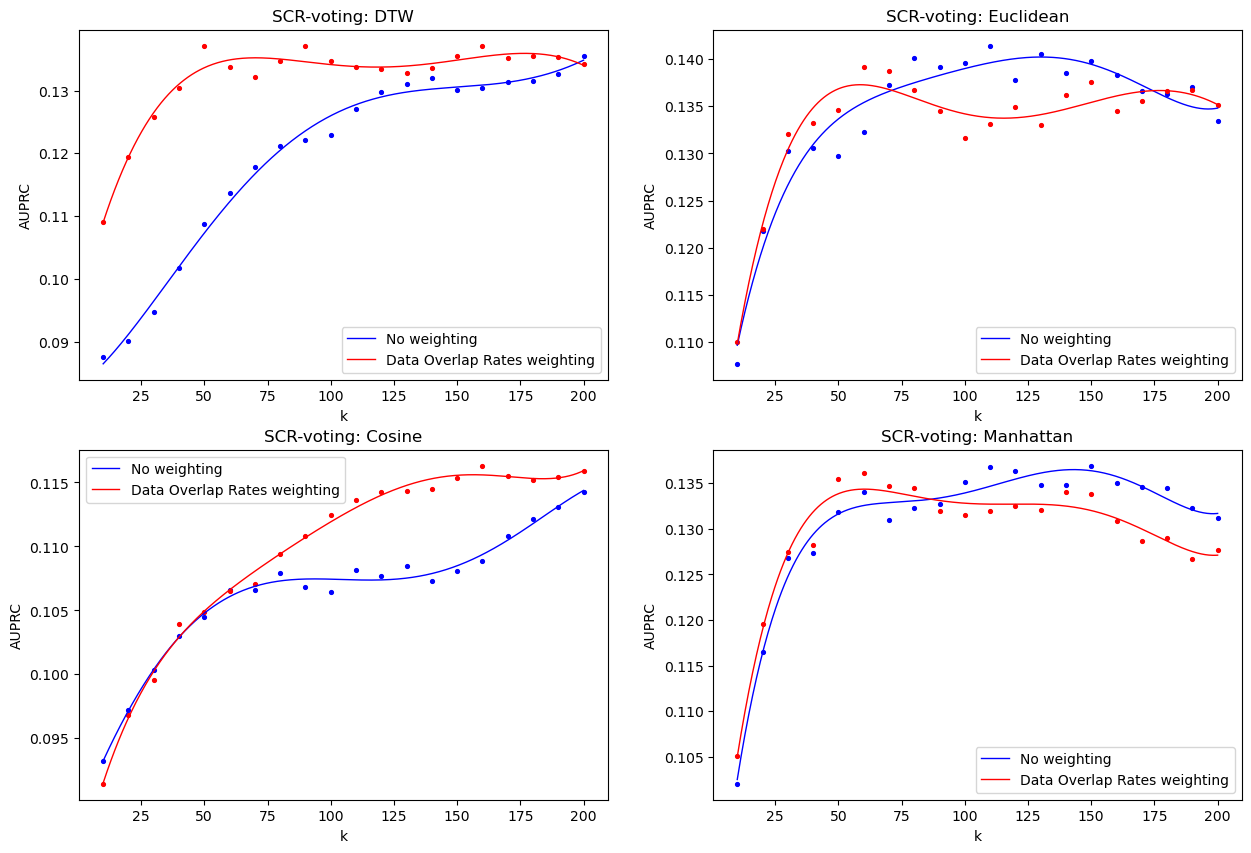

In [60]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10)) 

metric = "AUPRC"

plot_metric_along_k(axs[0,0], k_sizes_test, SCR_DTW_control_KNN["NW"][metric], SCR_DTW_control_KNN["WT"][metric], "SCR-voting: DTW", metric)
plot_metric_along_k(axs[0,1], k_sizes_test, SCR_Euc_control_KNN["NW"][metric], SCR_Euc_control_KNN["WT"][metric], "SCR-voting: Euclidean", metric)
plot_metric_along_k(axs[1,0], k_sizes_test, SCR_Cos_control_KNN["NW"][metric], SCR_Cos_control_KNN["WT"][metric], "SCR-voting: Cosine", metric)
plot_metric_along_k(axs[1,1], k_sizes_test, SCR_Manh_control_KNN["NW"][metric], SCR_Manh_control_KNN["WT"][metric], "SCR-voting: Manhattan", metric)

plt.show()

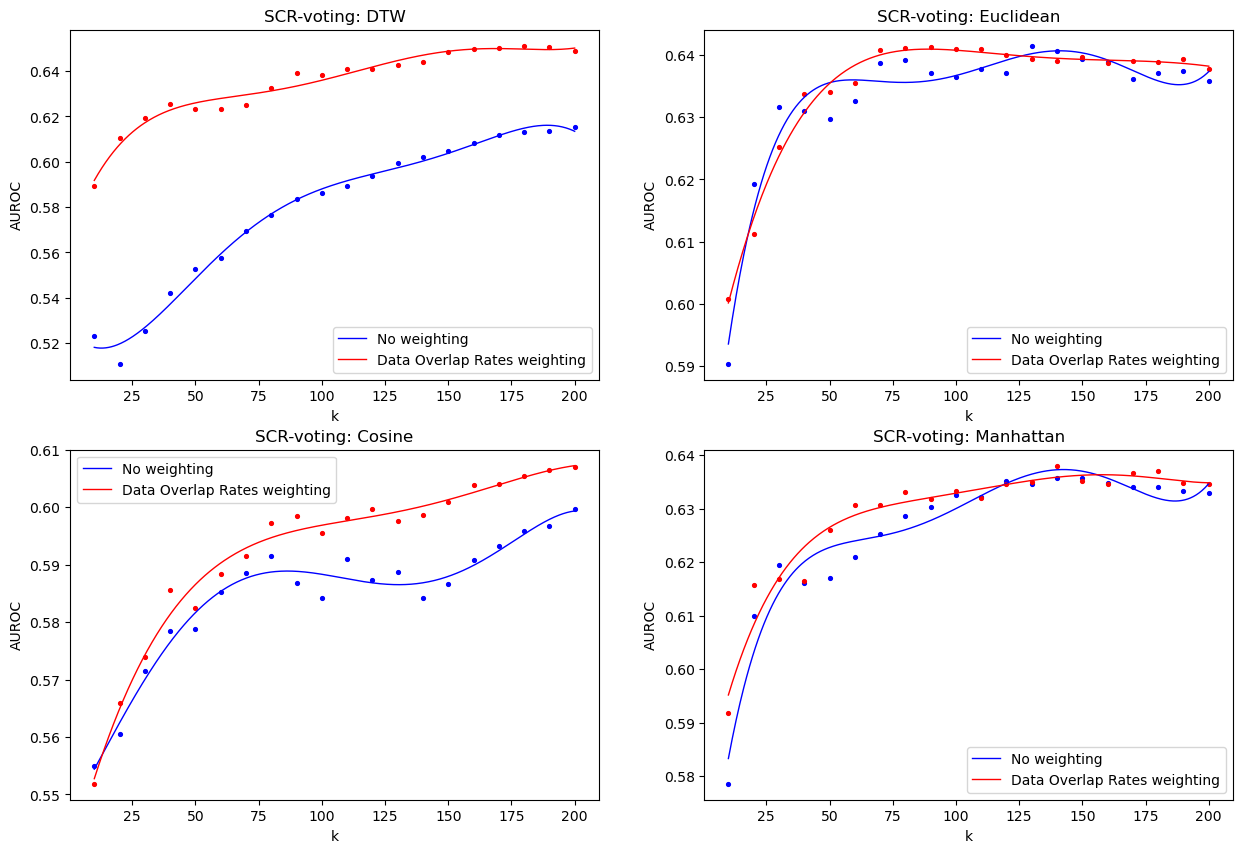

In [61]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10)) 

metric = "AUROC"

plot_metric_along_k(axs[0,0], k_sizes_test, SCR_DTW_control_KNN["NW"][metric], SCR_DTW_control_KNN["WT"][metric], "SCR-voting: DTW", metric)
plot_metric_along_k(axs[0,1], k_sizes_test, SCR_Euc_control_KNN["NW"][metric], SCR_Euc_control_KNN["WT"][metric], "SCR-voting: Euclidean", metric)
plot_metric_along_k(axs[1,0], k_sizes_test, SCR_Cos_control_KNN["NW"][metric], SCR_Cos_control_KNN["WT"][metric], "SCR-voting: Cosine", metric)
plot_metric_along_k(axs[1,1], k_sizes_test, SCR_Manh_control_KNN["NW"][metric], SCR_Manh_control_KNN["WT"][metric], "SCR-voting: Manhattan", metric)

plt.show()

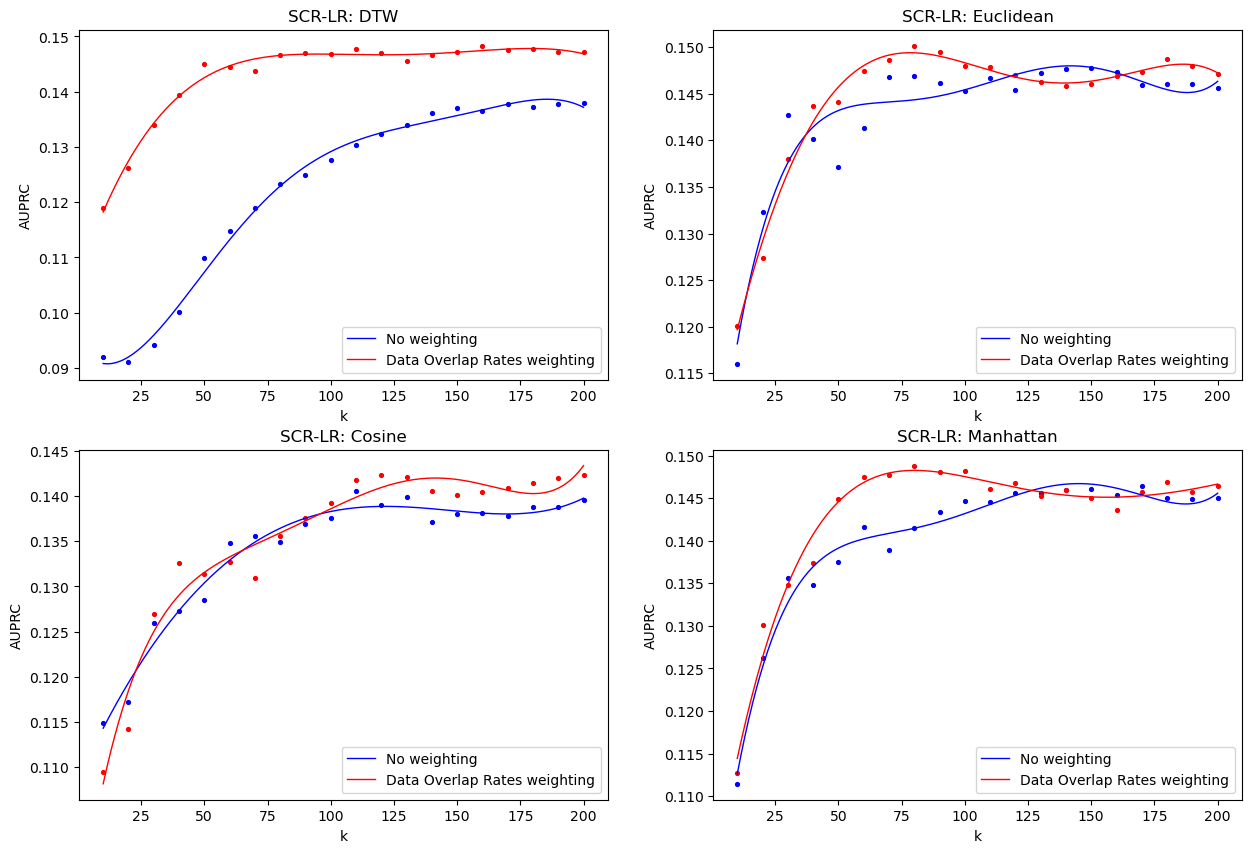

In [62]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10)) 

metric = "AUPRC"

plot_metric_along_k(axs[0,0], k_sizes_test, SCR_DTW_control_LR["NW"][metric], SCR_DTW_control_LR["WT"][metric], "SCR-LR: DTW", metric)
plot_metric_along_k(axs[0,1], k_sizes_test, SCR_Euc_control_LR["NW"][metric], SCR_Euc_control_LR["WT"][metric], "SCR-LR: Euclidean", metric)
plot_metric_along_k(axs[1,0], k_sizes_test, SCR_Cos_control_LR["NW"][metric], SCR_Cos_control_LR["WT"][metric], "SCR-LR: Cosine", metric)
plot_metric_along_k(axs[1,1], k_sizes_test, SCR_Manh_control_LR["NW"][metric], SCR_Manh_control_LR["WT"][metric], "SCR-LR: Manhattan", metric)

plt.show()

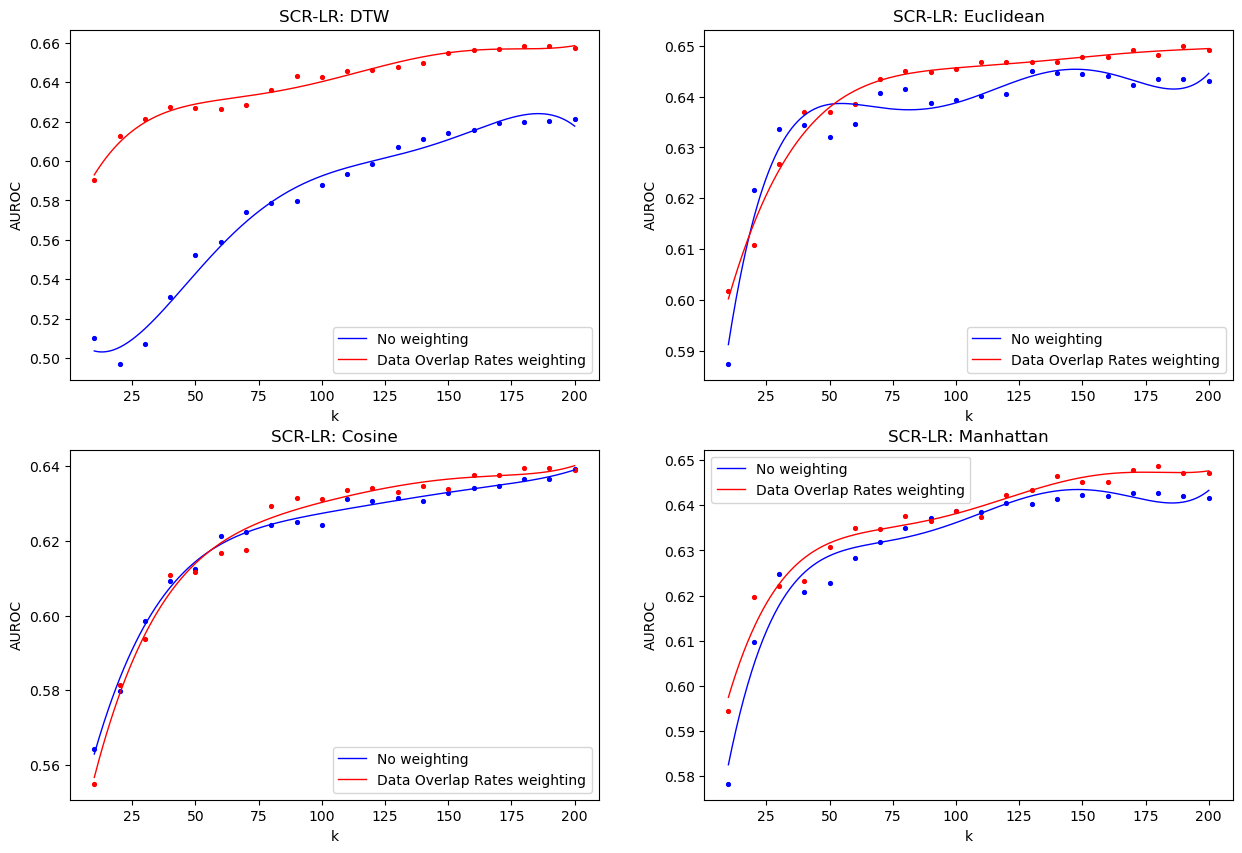

In [63]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10)) 

metric = "AUROC"

plot_metric_along_k(axs[0,0], k_sizes_test, SCR_DTW_control_LR["NW"][metric], SCR_DTW_control_LR["WT"][metric], "SCR-LR: DTW", metric)
plot_metric_along_k(axs[0,1], k_sizes_test, SCR_Euc_control_LR["NW"][metric], SCR_Euc_control_LR["WT"][metric], "SCR-LR: Euclidean", metric)
plot_metric_along_k(axs[1,0], k_sizes_test, SCR_Cos_control_LR["NW"][metric], SCR_Cos_control_LR["WT"][metric], "SCR-LR: Cosine", metric)
plot_metric_along_k(axs[1,1], k_sizes_test, SCR_Manh_control_LR["NW"][metric], SCR_Manh_control_LR["WT"][metric], "SCR-LR: Manhattan", metric)

plt.show()

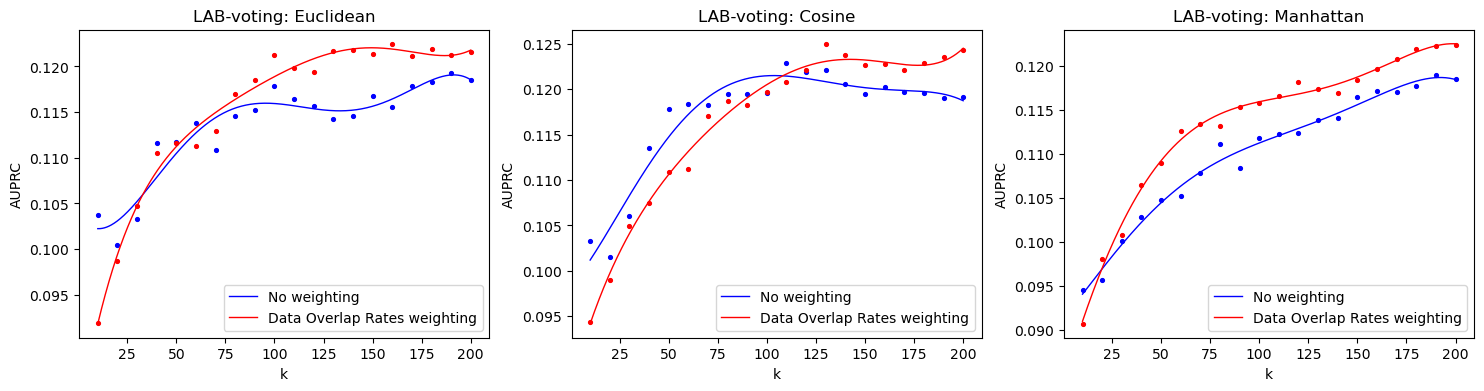

In [64]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4)) 

metric = "AUPRC"

plot_metric_along_k(axs[0], k_sizes_test, LAB_Euc_control_KNN["NW"][metric], LAB_Euc_control_KNN["WT"][metric], "LAB-voting: Euclidean", metric)
plot_metric_along_k(axs[1], k_sizes_test, LAB_Cos_control_KNN["NW"][metric], LAB_Cos_control_KNN["WT"][metric], "LAB-voting: Cosine", metric)
plot_metric_along_k(axs[2], k_sizes_test, LAB_Manh_control_KNN["NW"][metric], LAB_Manh_control_KNN["WT"][metric], "LAB-voting: Manhattan", metric)

plt.show()

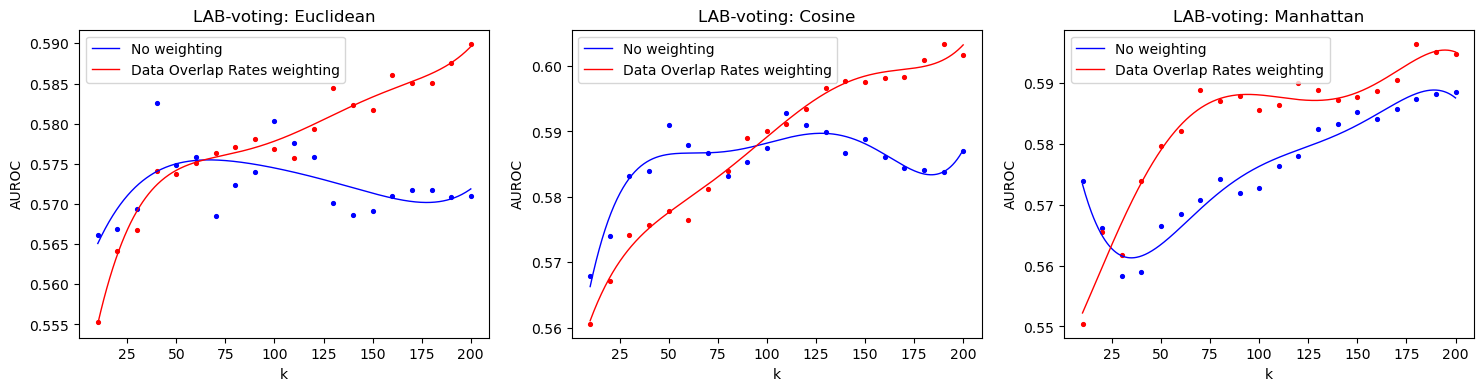

In [65]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4)) 

metric = "AUROC"

plot_metric_along_k(axs[0], k_sizes_test, LAB_Euc_control_KNN["NW"][metric], LAB_Euc_control_KNN["WT"][metric], "LAB-voting: Euclidean", metric)
plot_metric_along_k(axs[1], k_sizes_test, LAB_Cos_control_KNN["NW"][metric], LAB_Cos_control_KNN["WT"][metric], "LAB-voting: Cosine", metric)
plot_metric_along_k(axs[2], k_sizes_test, LAB_Manh_control_KNN["NW"][metric], LAB_Manh_control_KNN["WT"][metric], "LAB-voting: Manhattan", metric)

plt.show()

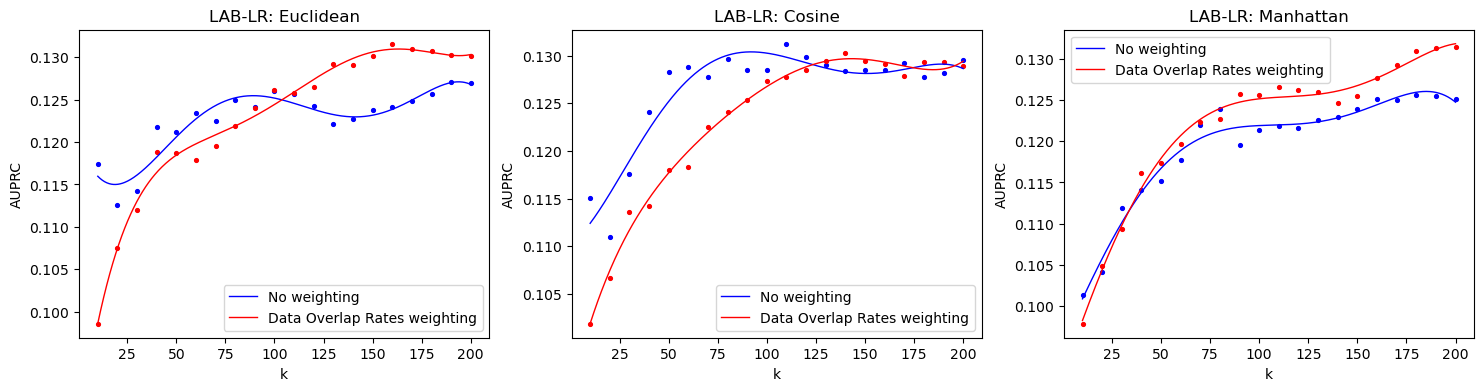

In [66]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4)) 

metric = "AUPRC"

plot_metric_along_k(axs[0], k_sizes_test, LAB_Euc_control_LR["NW"][metric], LAB_Euc_control_LR["WT"][metric], "LAB-LR: Euclidean", metric)
plot_metric_along_k(axs[1], k_sizes_test, LAB_Cos_control_LR["NW"][metric], LAB_Cos_control_LR["WT"][metric], "LAB-LR: Cosine", metric)
plot_metric_along_k(axs[2], k_sizes_test, LAB_Manh_control_LR["NW"][metric], LAB_Manh_control_LR["WT"][metric], "LAB-LR: Manhattan", metric)

plt.show()

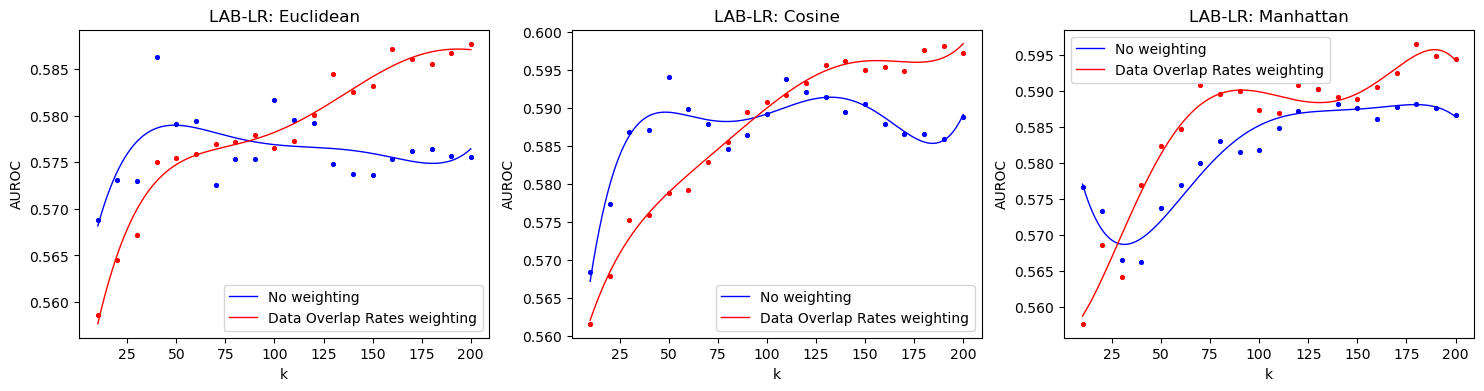

In [67]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4)) 

metric = "AUROC"

plot_metric_along_k(axs[0], k_sizes_test, LAB_Euc_control_LR["NW"][metric], LAB_Euc_control_LR["WT"][metric], "LAB-LR: Euclidean", metric)
plot_metric_along_k(axs[1], k_sizes_test, LAB_Cos_control_LR["NW"][metric], LAB_Cos_control_LR["WT"][metric], "LAB-LR: Cosine", metric)
plot_metric_along_k(axs[2], k_sizes_test, LAB_Manh_control_LR["NW"][metric], LAB_Manh_control_LR["WT"][metric], "LAB-LR: Manhattan", metric)

plt.show()

# Test Final Performance

In [68]:
from utils.Testing import test_final_personalized_model, get_best_weights, combine_best_weights_for_test, KNN, predict_by_LR

In [69]:
grid_search_table = pd.read_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/grid_search_table_imput2_LR.csv", index_col = 0)
best_distance_measures = dict()
for column in grid_search_table.columns:
    mode_value = grid_search_table[column].mode()[0]
    best_distance_measures[column] = mode_value

In [70]:
opt_SCR_simi_nw_full = nw_fea_arrs_dict["SCR"][best_distance_measures["SCR NW"]]["simi"]["full"]
opt_LAB_simi_nw_full = nw_fea_arrs_dict["LAB"][best_distance_measures["LAB NW"]]["simi"]["full"]
opt_SCR_simi_wt_full = wt_fea_arrs_dict["SCR"][best_distance_measures["SCR WT"]]["simi"]["full"]
opt_LAB_simi_wt_full = wt_fea_arrs_dict["LAB"][best_distance_measures["LAB WT"]]["simi"]["full"]

opt_measure_simi_nw_full_dict = {"SCR": opt_SCR_simi_nw_full, "LAB": opt_LAB_simi_nw_full}
opt_measure_simi_wt_full_dict = {"SCR": opt_SCR_simi_wt_full, "LAB": opt_LAB_simi_wt_full}

In [71]:
# these are the no nan features
X_train = pd.concat([SCR_train, LAB_train], axis = 1)
X_test = pd.concat([SCR_test, LAB_test], axis = 1)
assert X_train.shape[1] == X_test.shape[1]
# assert no nan values
assert not X_train.isnull().values.any(), "The DataFrame contains NaN values!"
assert not X_test.isnull().values.any(), "The DataFrame contains NaN values!"

Performance 1: Optimized distance measure + optimized feature type weights + no overlap rates weighting

In [72]:
final_model_performance_nw_KNN = test_final_personalized_model(X_train, X_test, k_sizes_test, grid_search_table, 
                                                           train_idx, test_idx, y_full, y_test, opt_measure_simi_nw_full_dict, 
                                                           num_processors, "KNN", False)

100%|██████████| 20/20 [03:45<00:00, 11.28s/it]


In [73]:
final_model_performance_nw_LR = test_final_personalized_model(X_train, X_test, k_sizes_test, grid_search_table, 
                                                           train_idx, test_idx, y_full, y_test, opt_measure_simi_nw_full_dict, 
                                                           num_processors, "LR", False)

100%|██████████| 20/20 [10:39<00:00, 31.98s/it]


Performance 2: Optimized distance measure + optimized feature type weights + overlap rates weighting

In [74]:
final_model_performance_wt_KNN = test_final_personalized_model(X_train, X_test, k_sizes_test, grid_search_table, 
                                                           train_idx, test_idx, y_full, y_test, opt_measure_simi_wt_full_dict, 
                                                           num_processors, "KNN", True)

100%|██████████| 20/20 [03:01<00:00,  9.08s/it]


In [75]:
final_model_performance_wt_LR = test_final_personalized_model(X_train, X_test, k_sizes_test, grid_search_table, 
                                                           train_idx, test_idx, y_full, y_test, opt_measure_simi_wt_full_dict, 
                                                           num_processors, "LR", True)

100%|██████████| 20/20 [10:35<00:00, 31.78s/it]


Performance 3: Fixed Euclidean distance + fixed feature type weights, k = 20 + no overlap rates weighting

In [76]:
base_k = 20
base_fix_distance_performance_nw_KNN = {"AUPRC": [], "AUROC": []}
base_fix_distance_performance_nw_LR = {"AUPRC": [], "AUROC": []}
A_nw, B_nw = eval(get_best_weights(grid_search_table, base_k, False))
base_fix_SCR_simi_nw_full = nw_fea_arrs_dict["SCR"]["DTW"]["simi"]["full"]
base_fix_LAB_simi_nw_full = nw_fea_arrs_dict["LAB"]["Euc"]["simi"]["full"]
fix_combined_weights_dict_nw = combine_best_weights_for_test(base_fix_SCR_simi_nw_full, base_fix_LAB_simi_nw_full, A_nw, B_nw, train_idx, test_idx, y_full, num_processors)

for k in tqdm(k_sizes_test):
    base_AUPRC_nw_KNN, base_AUROC_nw_KNN = KNN(fix_combined_weights_dict_nw, k, y_test)
    base_fix_distance_performance_nw_KNN["AUPRC"].append(base_AUPRC_nw_KNN)
    base_fix_distance_performance_nw_KNN["AUROC"].append(base_AUROC_nw_KNN)
    base_AUPRC_nw_LR, base_AUROC_nw_LR = predict_by_LR(X_train, X_test, fix_combined_weights_dict_nw, k, y_test)
    base_fix_distance_performance_nw_LR["AUPRC"].append(base_AUPRC_nw_LR)
    base_fix_distance_performance_nw_LR["AUROC"].append(base_AUROC_nw_LR)

100%|██████████| 20/20 [07:27<00:00, 22.35s/it]


Performance 4: Optimized distance measure + fixed feature type weights, k = 20 + no overlap rates weighting

In [77]:
base_opt_distance_performance_nw_KNN = {"AUPRC": [], "AUROC": []}
base_opt_distance_performance_nw_LR = {"AUPRC": [], "AUROC": []}
base_opt_SCR_simi_nw_full = nw_fea_arrs_dict["SCR"][best_distance_measures["SCR NW"]]["simi"]["full"]
base_opt_LAB_simi_nw_full = nw_fea_arrs_dict["LAB"][best_distance_measures["LAB NW"]]["simi"]["full"]
fix_combined_weights_dict_nw = combine_best_weights_for_test(base_opt_SCR_simi_nw_full, base_opt_LAB_simi_nw_full, A_nw, B_nw, train_idx, test_idx, y_full, num_processors)

for k in tqdm(k_sizes_test):
    base_AUPRC_nw_KNN, base_AUROC_nw_KNN = KNN(fix_combined_weights_dict_nw, k, y_test)
    base_opt_distance_performance_nw_KNN["AUPRC"].append(base_AUPRC_nw_KNN)
    base_opt_distance_performance_nw_KNN["AUROC"].append(base_AUROC_nw_KNN)
    base_AUPRC_nw_LR, base_AUROC_nw_LR = predict_by_LR(X_train, X_test, fix_combined_weights_dict_nw, k, y_test)
    base_opt_distance_performance_nw_LR["AUPRC"].append(base_AUPRC_nw_LR)
    base_opt_distance_performance_nw_LR["AUROC"].append(base_AUROC_nw_LR)

100%|██████████| 20/20 [07:16<00:00, 21.82s/it]


Performance 5: Global Euclidean Distance

In [78]:
X_train_norm = X_train.copy(deep = True)
X_test_norm = X_test.copy(deep = True) 
X_train_norm.loc[:, :] = min_max_normalization(X_train_norm, axis = 0)
X_test_norm.loc[:, :] = min_max_normalization(X_test_norm, axis = 0)
X_full_norm = pd.concat([X_train_norm, X_test_norm], axis = 0)

In [79]:
_, X_Euc_idx_full, _, _ = compute_similarity(X_full_norm, 'euclidean', train_len, num_processors)
Euc_idx_arr_test_glob, Euc_y_test_arr_glob = process_idx_arr_for_test(train_idx, test_idx, X_Euc_idx_full, y_full)
glob_Euc_idx_y_dict_test = {"idx": Euc_idx_arr_test_glob, "label": Euc_y_test_arr_glob}

In [80]:
base_glob_Euc_performance_KNN = {"AUPRC": [], "AUROC": []}
base_glob_Euc_performance_LR = {"AUPRC": [], "AUROC": []}
for k in tqdm(k_sizes_test):
    base_AUPRC_glob_KNN, base_AUROC_glob_KNN = KNN(glob_Euc_idx_y_dict_test, k, y_test)
    base_glob_Euc_performance_KNN["AUPRC"].append(base_AUPRC_glob_KNN)
    base_glob_Euc_performance_KNN["AUROC"].append(base_AUROC_glob_KNN)
    base_AUPRC_glob_LR, base_AUROC_glob_LR = predict_by_LR(X_train, X_test, glob_Euc_idx_y_dict_test, k, y_test)
    base_glob_Euc_performance_LR["AUPRC"].append(base_AUPRC_glob_LR)
    base_glob_Euc_performance_LR["AUROC"].append(base_AUROC_glob_LR)

100%|██████████| 20/20 [06:54<00:00, 20.70s/it]


Performance 6: Global Cosine Distance

In [81]:
_, X_Cos_idx_full, _, _ = compute_similarity(X_full_norm, 'cosine', train_len, num_processors)
Cos_idx_arr_test_glob, Cos_y_test_arr_glob = process_idx_arr_for_test(train_idx, test_idx, X_Cos_idx_full, y_full)
glob_Cos_idx_y_dict_test = {"idx": Cos_idx_arr_test_glob, "label": Cos_y_test_arr_glob}

In [82]:
base_glob_Cos_performance_KNN = {"AUPRC": [], "AUROC": []}
base_glob_Cos_performance_LR = {"AUPRC": [], "AUROC": []}
for k in tqdm(k_sizes_test):
    base_AUPRC_glob_KNN, base_AUROC_glob_KNN = KNN(glob_Cos_idx_y_dict_test, k, y_test)
    base_glob_Cos_performance_KNN["AUPRC"].append(base_AUPRC_glob_KNN)
    base_glob_Cos_performance_KNN["AUROC"].append(base_AUROC_glob_KNN)
    base_AUPRC_glob_LR, base_AUROC_glob_LR = predict_by_LR(X_train, X_test, glob_Cos_idx_y_dict_test, k, y_test)
    base_glob_Cos_performance_LR["AUPRC"].append(base_AUPRC_glob_LR)
    base_glob_Cos_performance_LR["AUROC"].append(base_AUROC_glob_LR)

100%|██████████| 20/20 [06:51<00:00, 20.57s/it]


# Plot the Final Performance of Personalized Models 

In [83]:
from utils.Plotting import plot_final_performance_metrics

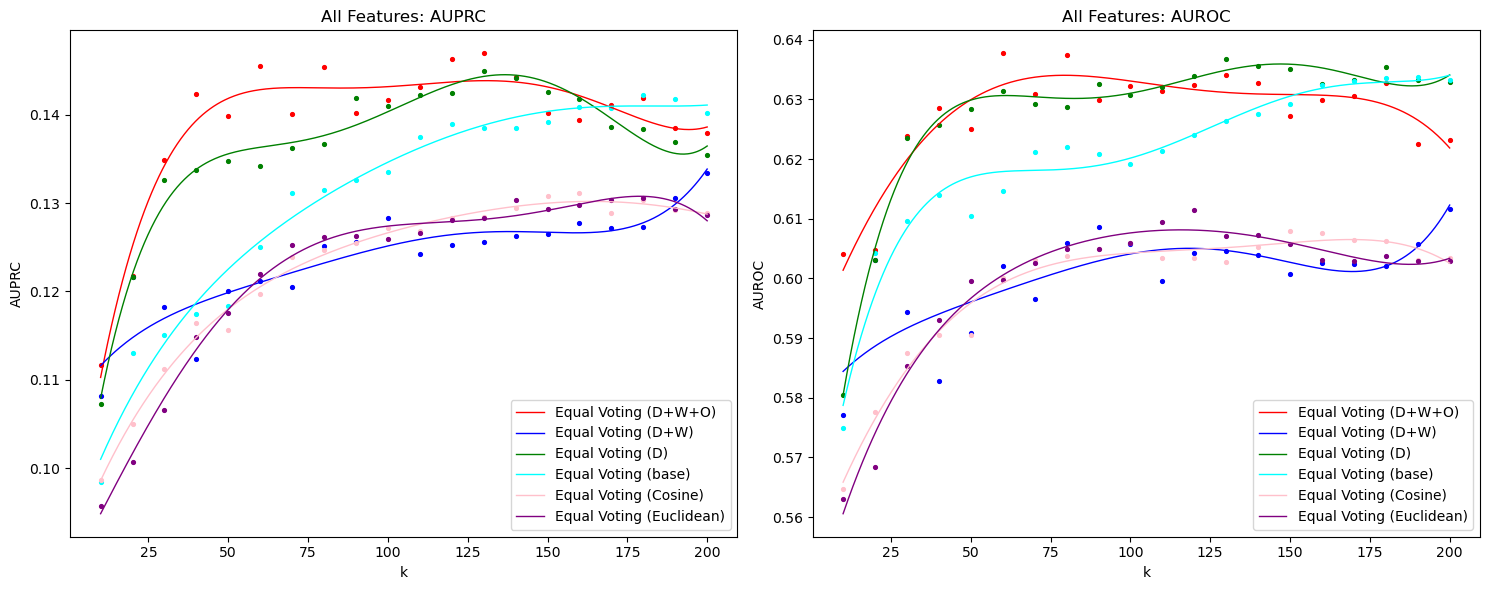

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6)) 

plot_final_performance_metrics(axs[0], k_sizes_test, "AUPRC", base_glob_Euc_performance_KNN, base_glob_Cos_performance_KNN, base_fix_distance_performance_nw_KNN, base_opt_distance_performance_nw_KNN, final_model_performance_nw_KNN, final_model_performance_wt_KNN, "Equal Voting")
plot_final_performance_metrics(axs[1], k_sizes_test, "AUROC", base_glob_Euc_performance_KNN, base_glob_Cos_performance_KNN, base_fix_distance_performance_nw_KNN, base_opt_distance_performance_nw_KNN, final_model_performance_nw_KNN, final_model_performance_wt_KNN, "Equal Voting")
plt.tight_layout()
plt.show()

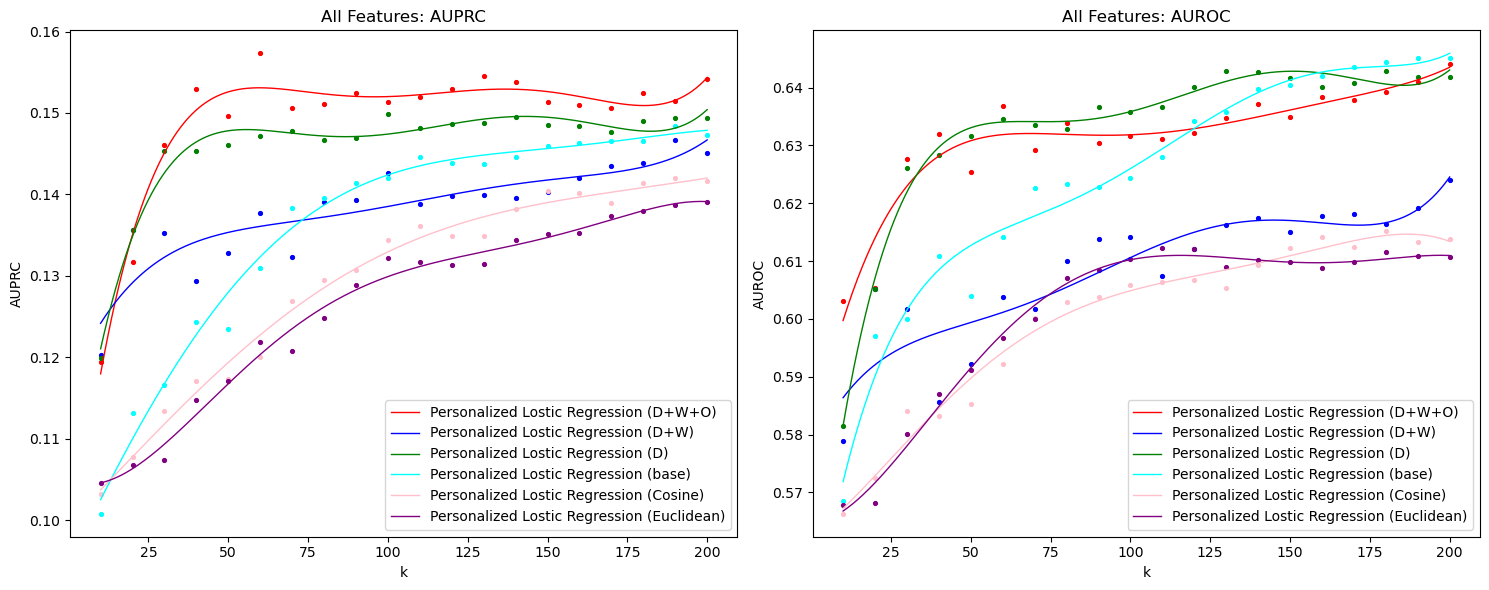

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6)) 

plot_final_performance_metrics(axs[0], k_sizes_test, "AUPRC", base_glob_Euc_performance_LR, base_glob_Cos_performance_LR, base_fix_distance_performance_nw_LR, base_opt_distance_performance_nw_LR, final_model_performance_nw_LR, final_model_performance_wt_LR, "Personalized Lostic Regression")
plot_final_performance_metrics(axs[1], k_sizes_test, "AUROC", base_glob_Euc_performance_LR, base_glob_Cos_performance_LR, base_fix_distance_performance_nw_LR, base_opt_distance_performance_nw_LR, final_model_performance_nw_LR, final_model_performance_wt_LR, "Personalized Lostic Regression")
plt.tight_layout()
plt.show()